<a href="https://colab.research.google.com/github/Gifourm/clothes_nn/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 [==============================] - 0s 69ms/step


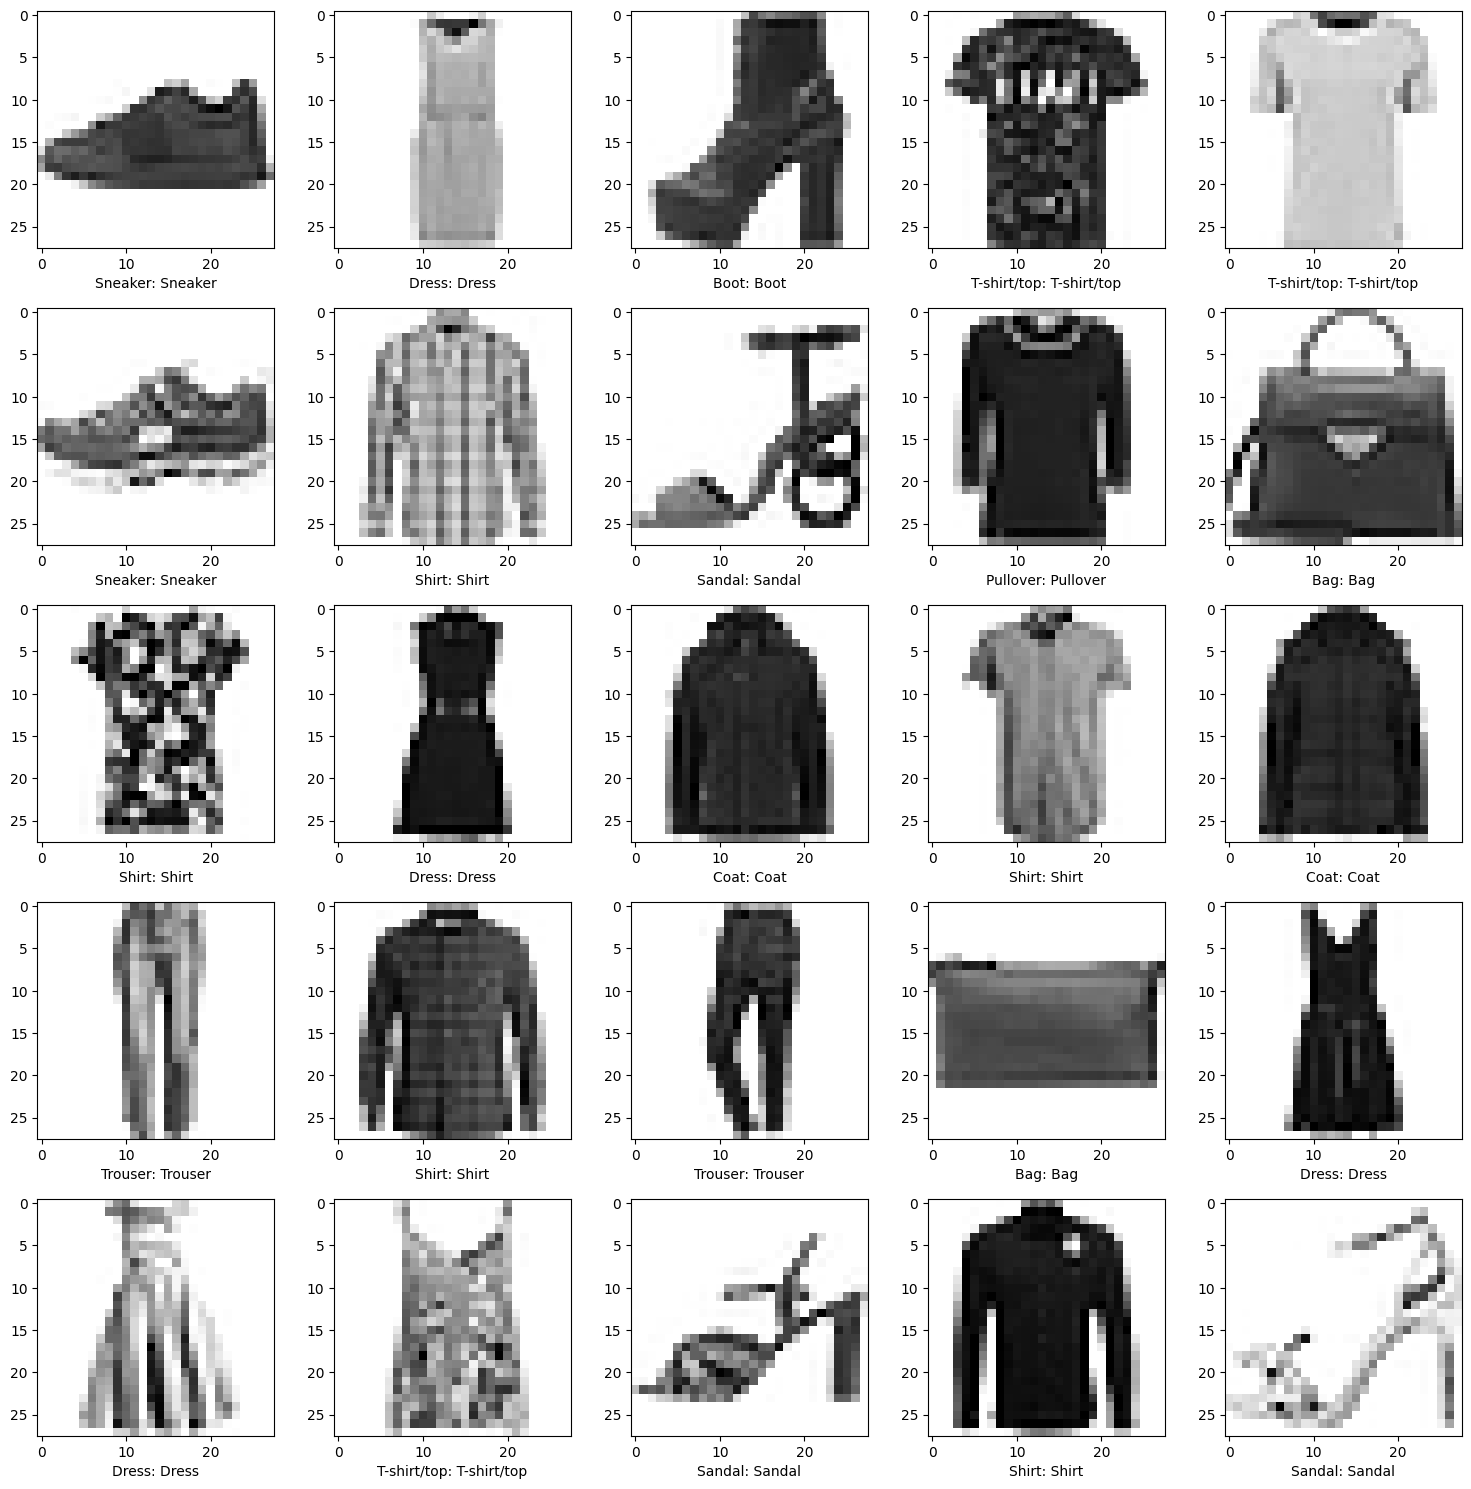

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy
import matplotlib.pyplot as plt


class Network(Model):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)


model = Network()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis].astype('float32')
x_test = x_test[..., tf.newaxis].astype('float32')

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(10000).batch(32)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


EPOCHS = 5
for epoch in range(EPOCHS):
  for var in (train_loss, train_accuracy, test_loss, test_accuracy):
    var.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, labels in test_ds:
    test_step(test_images, labels)

index = 12
image_subset = train_ds.skip(index).take(1)

for images, labels in image_subset:
    selected_image = images.numpy()
    selected_labels = labels.numpy()

predictions = model.predict(selected_image)

rows = 5
cols = 5
images_count = rows * cols
plt.figure(figsize=(cols * 3, rows * 3))
for i in range(images_count):
  plt.subplot(rows, cols, i+1)
  plt.imshow(selected_image[i], cmap=plt.cm.binary)
  plt.grid(False)
  plt.xlabel(f'{class_names[numpy.argmax(predictions[i])]}: {class_names[selected_labels[i]]}')

plt.tight_layout()
plt.show()